In [50]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import pypsa
import yaml

In [51]:
RUNS = { "no rule": "decr_14_3h_ws",
        "annual": "decr_16_3h_ws",
        "monthly": "decr_15_3h_ws",
        "hourly": "decr_13_3h_ws",
       }

ghrules = ["no rule","annual", "monthly", "hourly"]

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
OUTPUT = PREFIX + "results/gh/"
config_aldehyde = PREFIX + "config/config.yaml"

In [52]:
n = pypsa.Network("../subworkflows/pypsa-earth-sec/results/decr_13_3H_ws/postnetworks/elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_20export.nc")

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [53]:
def load_config(config_aldehyde):
    with open(config_aldehyde, 'r') as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return config

In [54]:
def get_data(stats, h2export, opts):
    """Filter stats according to h2export value and opts value
    """
    cost = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"cost"]
    mg_AC_exclu_H2 = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"mg_AC_exclu_H2 El_all"]
    mg_H2_False_False_exportonly = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"mg_H2_False_False_exportonly"]
    exp_AC_exclu_H2 = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"exp_AC_exclu_H2 El_all"]
    exp_H2_False_False_exportonly = stats[(stats.index == h2export) & (stats.opts == opts)].loc[:,"exp_H2_False_False_exportonly"]

    return cost, mg_AC_exclu_H2, mg_H2_False_False_exportonly, exp_AC_exclu_H2, exp_H2_False_False_exportonly

In [55]:
def prepare_data(ghrules, h2export, opts):
    df = pd.DataFrame(index=ghrules, columns=["cost", "mg_AC_exclu_H2", "mg_H2_False_False_exportonly"])

    for rule in ghrules:
        INPUT = PREFIX + "results/" + RUNS[rule] + "/integrated_comp/stats.csv"
        stats = pd.read_csv(INPUT, index_col=0)
        cost, mg_AC_exclu_H2, mg_H2_False_False_exportonly, exp_AC_exclu_H2, exp_H2_False_False_exportonly = get_data(stats, h2export, opts)    
        df.loc[rule, "cost"] = cost.values[0]
        df.loc[rule, "mg_AC_exclu_H2"] = mg_AC_exclu_H2.values[0]
        df.loc[rule, "mg_H2_False_False_exportonly"] = mg_H2_False_False_exportonly.values[0]    
        df.loc[rule, "exp_AC_exclu_H2"] = exp_AC_exclu_H2.values[0]
        df.loc[rule, "exp_H2_False_False_exportonly"] = exp_H2_False_False_exportonly.values[0]

    # Add relative values in % based on no rule row
    df["cost_rel"] = df["cost"] / df.loc["no rule", "cost"] * 100
    df["mg_AC_exclu_H2_rel"] = df["mg_AC_exclu_H2"] / df.loc["no rule", "mg_AC_exclu_H2"] * 100
    df["mg_H2_False_False_exportonly_rel"] = df["mg_H2_False_False_exportonly"] / df.loc["no rule", "mg_H2_False_False_exportonly"] * 100
    return df  

### Relative, subplot

In [56]:
h2exports = [200, 1]
opts = ["Co2L2.0", "Co2L0.00"]

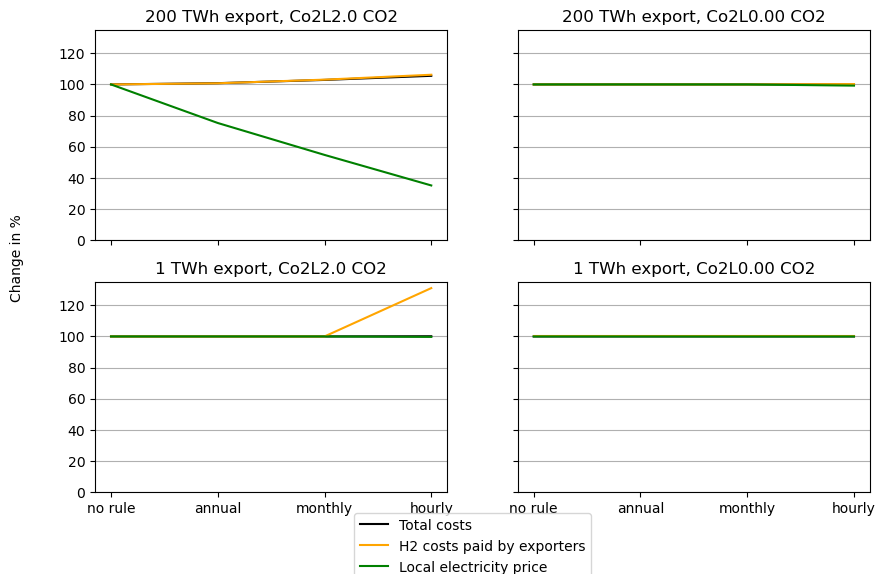

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

n=1
for h2export in h2exports:
    for o in opts:
        ax = plt.subplot(2, 2, n)
        n += 1

        df = prepare_data(ghrules, h2export, o)

        ax.plot(df.index, df["cost_rel"], label="Total costs", color="black")
        ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange")
        ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green")

        ax.set_title(f"{h2export} TWh export, {o} CO2")
        ax.grid(axis='y')
        ax.set_ylim(0, 135)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.4,-0.01))
fig.text(0.04, 0.5, 'Change in %', va='center', rotation='vertical')

fig.savefig(OUTPUT+"subplot.pdf", bbox_inches="tight")
fig.show()

### Get realistic scenarios

In [58]:
def get_realistic_scenarios(h2exports, opts, upper_band, lower_band):

    h2exports = h2exports[::-1]
    # Creating a DataFrame with the specified index and columns
    df = pd.DataFrame(index=h2exports, columns=opts)

    # Filling the DataFrame with the combination of both arrays
    for row_label in h2exports:
        for col_label in opts:
            df.at[row_label, col_label] = f'{row_label}-{col_label}'
            df.at[row_label, col_label] = [row_label, col_label]

    realistic_scenarios = []
    for offset in range(lower_band, upper_band + 1):
        diagonal_values = np.diagonal(df.values[::-1], offset=offset)
        realistic_scenarios.extend(diagonal_values)

    return realistic_scenarios

In [59]:
def isin_realistic_scenario(h2export, opt, realistic_scenarios):

    # Combination of two values to check
    value_to_check = [h2export, opt]

    # Check if the combination is in the array
    combination_exists = any(all(x == y for x, y in zip(value_to_check, sublist)) for sublist in realistic_scenarios)

    return combination_exists

### Relative, multiple in one

In [60]:
#h2exports = [1, 20 , 40, 60, 80, 100, 120, 140, 160, 180, 200]
h2exports = [1, 20, 40, 60, 80, 100, 120]
# h2exports = [1, 20 , 40]
# h2exports = [60, 80, 100, 120]
# h2exports = [140, 160, 180, 200]
#h2exports = [1, 20] # these are the outliers above 7% in combination with opts = ["Co2L2.0"]
h2exports = [40]
opts = ["Co2L0.90"]
#opts = ["Co2L2.0", "Co2L0.90",]# "Co2L0.80", "Co2L0.70", "Co2L0.60", "Co2L0.50", "Co2L0.40", "Co2L0.30", "Co2L0.20", "Co2L0.10", "Co2L0.00"]
#opts = ["Co2L2.0", "Co2L0.90", "Co2L0.80"]
# opts = ["Co2L0.70", "Co2L0.60", "Co2L0.50", "Co2L0.40",]
# opts = ["Co2L0.30", "Co2L0.20", "Co2L0.10", "Co2L0.00"]
realistic = "additional" # Can be "only", "additional", or "false"
ghrules = ["no rule","annual", "monthly", "hourly"]
lower_band = -1 # Allow more towards h2export, negative
upper_band = 1 # Allow more towards decarbonisation, positive

In [61]:
min_domestic_real = 100
min_domestic = 100
for h2export in h2exports:
    for o in opts:

        df = prepare_data(ghrules, h2export, o)
        df_rel = df / df.loc["no rule"] * 100  
        
        if isin_realistic_scenario(h2export, o, realistic_scenarios):

            if df_rel["exp_AC_exclu_H2"].min() < min_domestic_real:
                min_domestic_real = df_rel["exp_AC_exclu_H2"].min() 

        if df_rel["exp_AC_exclu_H2"].min() < min_domestic:
            min_domestic = df_rel["exp_AC_exclu_H2"].min()
print(f"Max domestic electricity reduction: {100-min_domestic:.2f} %")
print(f"Max realistic domestic electricity reduction: {100-min_domestic_real:.2f} %")

Max domestic electricity reduction: 31.10 %
Max realistic domestic electricity reduction: 31.10 %


In [62]:
realistic_scenarios = get_realistic_scenarios(h2exports, opts, upper_band, lower_band)

In [63]:
realistic_scenarios

[[40, 'Co2L0.90']]

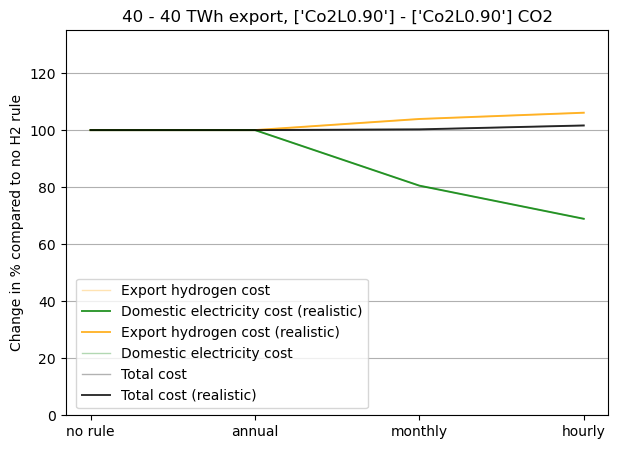

In [64]:
fig, ax = plt.subplots(figsize=(7, 5))

realistic_scenarios = get_realistic_scenarios(h2exports, opts, upper_band, lower_band)

for h2export in h2exports:
    for o in opts:

        df = prepare_data(ghrules, h2export, o)

        # # Relative prices
        # ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        # ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
        # ax.plot(df.index, df["cost_rel"], label="Total costs", color="black", linewidth=1, alpha=0.3)

        # if isin_realistic_scenario(h2export, o, realistic_scenarios):
        #     ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters (realistic)", color="orange", linewidth=1.7,  alpha=1)
        #     ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price (realistic)", color="green", linewidth=1.7, alpha=1)
        #     ax.plot(df.index, df["cost_rel"], label="Total costs (realistic)", color="black", linewidth=1.7, alpha=1)

        # Relative expenses
        df_rel = df / df.loc["no rule"] * 100   
        if realistic != "only":

            ax.plot(df.index, df_rel["exp_H2_False_False_exportonly"], label="Export hydrogen cost", color="orange", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
            ax.plot(df.index, df_rel["exp_AC_exclu_H2"], label="Domestic electricity cost", color="green", linewidth=1, alpha=0.3)#alpha=1-(h2export/200)*0.7)
            ax.plot(df.index, df_rel["cost_rel"], label="Total cost", color="black", linewidth=1, alpha=0.3)

        if realistic != "false":
            if isin_realistic_scenario(h2export, o, realistic_scenarios):
                ax.plot(df.index, df_rel["exp_H2_False_False_exportonly"], label="Export hydrogen cost (realistic)", color="orange", linewidth=1.4,  alpha=0.8)
                ax.plot(df.index, df_rel["exp_AC_exclu_H2"], label="Domestic electricity cost (realistic)", color="green", linewidth=1.4, alpha=0.8)
                ax.plot(df.index, df_rel["cost_rel"], label="Total cost (realistic)", color="black", linewidth=1.4, alpha=0.8)


ax.set_title(f"{min(h2exports)} - {max(h2exports)} TWh export, {opts[:1]} - {opts[-1:]} CO2")
ax.grid(axis='y')
ax.set_ylim(0, 135)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))  # Get unique labels
unique_handles = [handles[labels.index(label)] for label in unique_labels]  # Get corresponding handles

#fig.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.55, 0.5))
fig.legend(unique_handles, unique_labels, loc='lower left', bbox_to_anchor=(0.13, 0.11))

ax.set_ylabel("Change in % compared to no H2 rule")

fig.savefig(OUTPUT+"rel_multiple_" + str(max(h2exports)) +"exp_"+  str(opts[0]) + "dec_" + realistic + "real" ".pdf", bbox_inches="tight")

plt.show()

### Relative, single

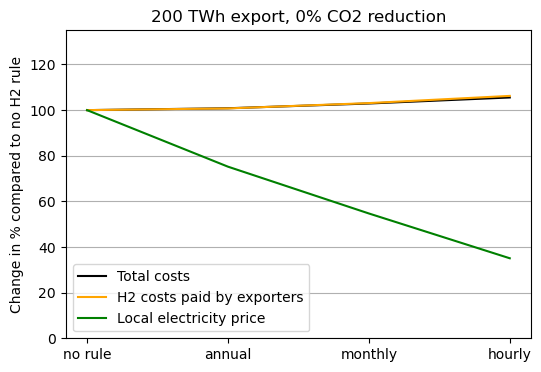

In [65]:
df = prepare_data(ghrules, 200, "Co2L2.0")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df.index, df["cost_rel"], label="Total costs", color="black")
ax.plot(df.index, df["mg_H2_False_False_exportonly_rel"], label="H2 costs paid by exporters", color="orange")
ax.plot(df.index, df["mg_AC_exclu_H2_rel"], label="Local electricity price", color="green")

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Change in % compared to no H2 rule")
ax.set_title(f"200 TWh export, 0% CO2 reduction")
ax.set_ylim(0, 135)
ax.grid(axis='y')

ax.legend(loc="lower left")

### Absolute prices

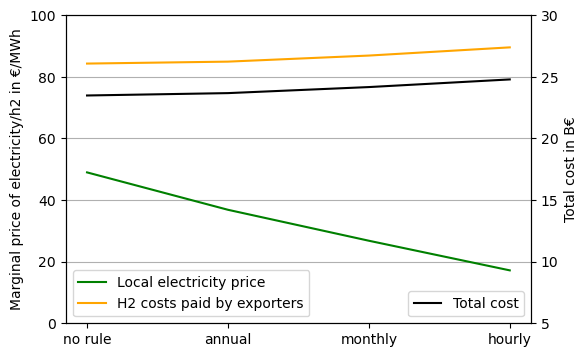

In [66]:
df = prepare_data(ghrules, 200, "Co2L2.0")
fig, ax = plt.subplots(figsize=(6, 4))

#ax.plot(df.index, df["cost"]/1e9, label="Total cost")
ax.plot(df.index, df["mg_AC_exclu_H2"], label="Local electricity price", color="green")
ax.plot(df.index, df["mg_H2_False_False_exportonly"], label="H2 costs paid by exporters", color="orange")


# Add secondary axis for total cost
ax2 = ax.twinx()
ax2.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")
ax2.set_ylabel("Total cost in B€")
ax2.set_ylim(5, 30)

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Marginal price of electricity/h2 in €/MWh")
ax.set_ylim(0, 100)

ax.legend(loc="lower left")
ax2.legend(loc="lower right")

ax.grid(axis='y')

### Absolute expenses

In [132]:
h2export = 120
opts = "Co2L2.0"

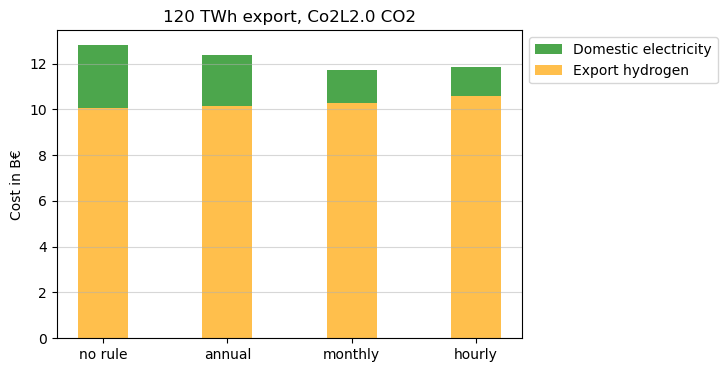

In [133]:
df = prepare_data(ghrules, h2export, opts)
# Decrease of domestic AC expenses from 2.8 B€ to 1.0 B€
# Increase of export H2 expenses from 16.9 B€ to 17.9 B€
fig, ax = plt.subplots(figsize=(6, 4))

width = 0.4
ax.bar(df.index, df["exp_H2_False_False_exportonly"]/1e3, width=width, label="Export hydrogen", color="orange", alpha=0.7)
ax.bar(df.index, df["exp_AC_exclu_H2"]/1e3, bottom=df["exp_H2_False_False_exportonly"]/1e3, width=width, label="Domestic electricity", color="green", alpha=0.7)
#ax.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")

ax.set_ylabel("Cost in B€")
#ax.set_ylim(0, 27)

#ax.set_xlabel("H2 rule")
ax.set_title(f"{h2export} TWh export, {opts} CO2")

# Reverse legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))

ax.grid(axis='y', alpha=0.5)   

fig.savefig(OUTPUT+f"abs_sin_expenses_h2ac_{h2export}_{opts}.pdf", bbox_inches="tight")

In [136]:
# export hydrogen
df["exp_H2_False_False_exportonly"]/1e3

no rule    10.071878
annual     10.144516
monthly    10.268477
hourly     10.586587
Name: exp_H2_False_False_exportonly, dtype: float64

In [138]:
# domestic electricity
df["exp_AC_exclu_H2"]/1e3

no rule    2.743634
annual     2.243767
monthly    1.469064
hourly     1.248425
Name: exp_AC_exclu_H2, dtype: float64

In [142]:
# Relative decrease
(df["exp_AC_exclu_H2"]["no rule"] - df["exp_AC_exclu_H2"]["hourly"]) / (df["exp_AC_exclu_H2"]["no rule"])

0.5449737623083357

In [144]:
# Absolute decrease
(df["exp_AC_exclu_H2"]["no rule"] - df["exp_AC_exclu_H2"]["hourly"]) / 1e3

1.4952083164921908

### All average nodal prices

In [69]:
def get_mean_prices(stats, h2export, opts):
    """Filter stats according to h2export value and opts value
    """
    stats = stats[(stats.index == h2export) & (stats.opts == opts)]
    stats = stats.iloc[:, stats.columns.str.startswith("mean_mg")]

    return stats

In [70]:
def prepare_mean_prices(ghrules, h2export, opts):
    df = pd.DataFrame() #index=ghrules)

    for rule in ghrules:
        INPUT = PREFIX + "results/" + RUNS[rule] + "/integrated_comp/stats.csv"
        stats = pd.read_csv(INPUT, index_col=0)
        prices = get_mean_prices(stats, h2export, opts)    
        prices.index = [rule]
        df = pd.concat([df, prices])

    return df  

In [71]:
h2export = 200
opts = "Co2L2.0"
increase = 0.04 # Percentage of increase above which it is considered as increase. Set "False" to allow all marginal prices

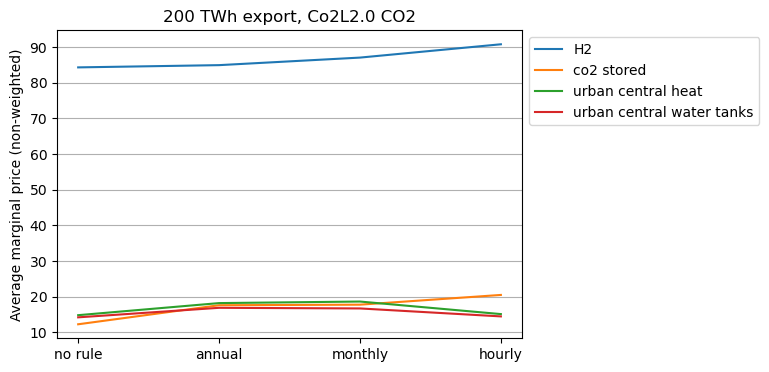

In [72]:
df = prepare_mean_prices(ghrules, h2export, opts)

if increase != False:
    # Filter df for columns which have higher values in any row (apart from "no rule") than in "no rule"
    df = df.loc[:, (df.loc[["hourly", "monthly", "annual"]] > (df.loc["no rule"]*(1+increase/100))).any()]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df.index, df, label=df.columns.str.replace("mean_mg_", ''))

#ax.set_xlabel("H2 rule")
ax.set_ylabel("Average marginal price (non-weighted)")
ax.set_title(f"{h2export} TWh export, {opts} CO2")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.grid(axis='y')

### System cost by expense

In [73]:
h2export = 120
opts = "Co2L0.00"

In [74]:
EXPORT = h2export
CO2L = 0.00
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.13

RUN = "decr_13_3h_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"

In [75]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [76]:
# TODO simplify this. df.loc["no rule"] is the same as -(n.statistics.revenue(comps=["Load"]) /1e9).droplevel(0)

In [77]:
n.objective / 1e9

25.82415228507718

In [78]:
def get_expense_carrier(n, excl_em=True):

    # Multiply demands and prices
    loads = n.loads_t.p[n.loads.index]
    loads.columns = n.loads.bus # Rename columns to bus names to comply with columns of "prices"
    prices = n.buses_t.marginal_price[n.loads.bus]
    expenses = loads * prices * n.snapshot_weightings.generators[0]

    nodal_expense = expenses.sum() #.groupby(n.loads.bus).sum() / 1e9
    nodal_expense.name = "expense"

    # concat loads_carrier and nodal_expense based on index
    loads_carrier = n.loads.carrier
    loads_carrier.index = n.loads.bus 
    nodal_expense_m = pd.concat([nodal_expense, loads_carrier], axis=1)

    expense_c = nodal_expense_m.groupby("carrier").sum() / 1e9

    if excl_em == True:
        expense_c = expense_c[~expense_c.index.str.contains("emission")]
    else:
        pass

    # # Alternative calc method
    # expenses = n.statistics.revenue() #[n.statistics.revenue() < 0]
    # expenses = expenses.droplevel(0)
    # expense_c = pd.DataFrame(expenses / 1e9)

    return expense_c

In [79]:
def get_expense_carriers(ghrules, h2export, opts, excl_em):
    """Get expense per carrier
    """

    df = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        expense_c = get_expense_carrier(n, excl_em=excl_em)
        expense_c = expense_c.T
        expense_c.index = [rule]
        expense_c.columns.name = None

        df = pd.concat([df, expense_c])

        
    return df

In [80]:
def prep_expense_carriers(df):
   # Combine the columns containing "AC" or "electricity" to one col and delete the others
   combine_cols = df.columns[df.columns.str.contains("electricity")]
   ev = "land transport EV"

   if ev in df.columns:
      df["Local electricity"] =  df[combine_cols].sum(axis=1) + df["AC"] + df["land transport EV"]
      df = df.drop(columns=["AC", "land transport EV"])
   else:
      df["Local electricity"] =  df[combine_cols].sum(axis=1) + df["AC"]
      df = df.drop(columns=["AC"])
   
   df = df.drop(columns=combine_cols)

   move = ["H2", "Local electricity"]
   keep = df.columns[~df.columns.isin(move)]
   df = df[move + list(keep)]

   return df

In [81]:
df = get_expense_carriers(ghrules, h2export, opts, excl_em=True)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [82]:
df_plot = prep_expense_carriers(df)

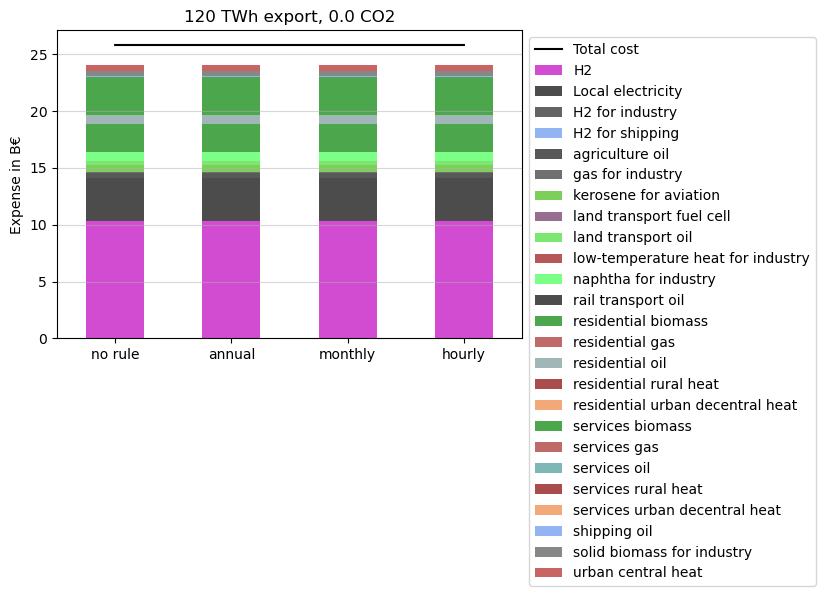

In [83]:
fig, ax = plt.subplots(figsize=(6, 4))

df_cost = prepare_data(ghrules, h2export, opts)
config = load_config(config_aldehyde)
colors = config["plot"]["tech_colors"]

plt.plot(df.index, df_cost["cost"]/1e9, label="Total cost", color="black")
df_plot.plot.bar(ax=ax, stacked=True, alpha=0.7, color=colors)

#plt.xlabel("H2 rule")
plt.ylabel("Expense in B€")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.5) 
plt.xticks(rotation=0)

fig.savefig(OUTPUT+f"abs_sin_expenses_{h2export}_{opts}.pdf", bbox_inches="tight")

### System costs by technology

In [84]:
# Theory: total system cost = n.objective
(n.statistics.capex().sum() - n.statistics.installed_capex().sum()) - (n.statistics.capex() - n.statistics.installed_capex()).sum()

3.814697265625e-06

In [85]:
def get_costs(threshold, ghrules, h2export, opts):
    """Get costs
    """

    costs = pd.DataFrame()

    for rule in ghrules:


        SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{h2export}export"
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        # Prepare CAPEX
        capex = n.statistics.capex() - n.statistics.installed_capex()
        threshold_sum_capex = capex[capex < threshold].sum() / 1e9
        capex = capex[capex > threshold] / 1e9 # in B€
        capex = pd.DataFrame(capex.droplevel(0)).T
        capex = capex.add_suffix(" (CAPEX)")
        capex[f"(CAPEX < {threshold/1e6} M€ thres.)"] = threshold_sum_capex

        # Rename H2 to H2 Storage
        capex = capex.rename(columns={"H2 (CAPEX)": "H2 Storage (CAPEX)"})

        # Prepare OPEX
        opex = n.statistics.opex()
        threshold_sum_opex = opex[opex < threshold].sum() / 1e9
        opex = opex[opex > threshold] / 1e9
        opex = pd.DataFrame(opex.droplevel(0)).T
        opex = opex.add_suffix(" (OPEX)")
        opex[f"(OPEX < {threshold/1e6} M€ thres.)"] = threshold_sum_opex
        opex =opex.groupby(opex.columns, axis=1).sum()

        # Combine CAPEX and OPEX
        caop = pd.concat([capex, opex], axis=1)
        caop.index = [rule]

        # Add to costs df
        costs = pd.concat([costs, caop], axis=0) #, ignore_index=True)

    
    return costs

In [86]:
threshold = 100e6 # M€

In [87]:
h2export = 120
opts = "Co2L2.0"

In [88]:
costs = get_costs(threshold, ghrules, h2export, opts)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [89]:
costs

carrier,Onshore Wind (CAPEX),Solar (CAPEX),H2 Electrolysis (CAPEX),Open-Cycle Gas (CAPEX),(CAPEX < 100.0 M€ thres.),(OPEX < 100.0 M€ thres.),Coal (OPEX),Combined-Cycle Gas (OPEX),Oil (OPEX),gas (OPEX),solid biomass (OPEX),H2 Storage (CAPEX)
no rule,0.996321,4.037112,2.532186,0.145143,0.182186,0.204453,1.283633,0.652341,5.921241,0.641369,0.162140,NaN
annual,1.251197,4.754988,2.762454,NaN,0.217905,0.166074,1.131577,0.354780,5.921192,0.176987,0.162173,NaN
monthly,1.734632,5.047443,2.723530,NaN,0.181559,0.096056,0.937263,0.175967,5.921238,0.116633,0.162140,0.170462
hourly,1.566359,5.524658,3.235027,NaN,0.106461,0.097096,0.612078,NaN,5.921202,0.162298,0.162142,0.290836


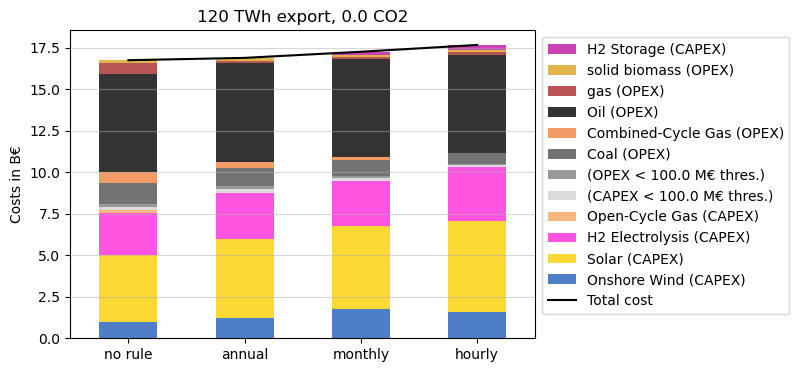

In [90]:
df = prepare_data(ghrules, h2export, opts)

fig, ax = plt.subplots(figsize=(6, 4))

config = load_config(config_aldehyde)
colors = config["plot"]["tech_colors"]
plt.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")
costs.plot.bar(ax=ax, stacked=True, alpha=0.8, color=colors)


#plt.xlabel("H2 rule")
plt.ylabel("Costs in B€")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

plt.grid(axis='y', alpha=0.5) 

fig.savefig(OUTPUT+f"abs_sin_tech_{h2export}_{opts}.pdf", bbox_inches="tight")

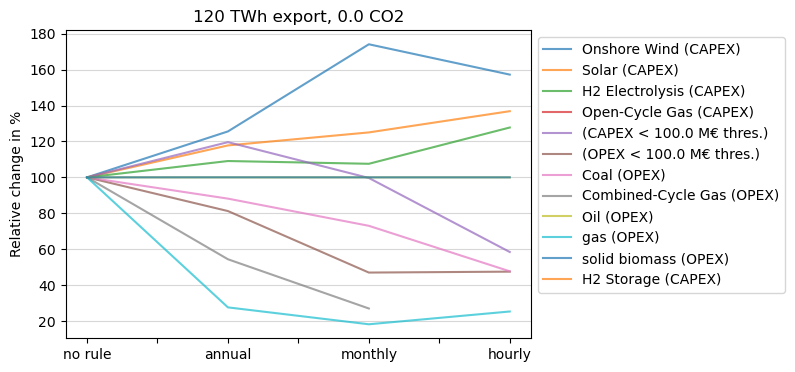

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))

# Divide all values by first row
costs_rel = costs / costs.iloc[0] *100

costs_rel.plot.line(ax=ax, alpha=0.7)
#plt.plot(df.index, df["cost"]/1e9, label="Total cost", color="black")

# plt.xlabel("H2 rule")
plt.ylabel("Relative change in %")
plt.title(f"{h2export} TWh export, {CO2L} CO2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.5) 

### Dispatch

In [145]:
threshold_dispatch = 1e6 # 4 TWh
h2export = 120
opts = "Co2L2.0"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{h2export}export"


In [146]:
def get_dispatch(threshold_dispatch, ghrules, h2export, opts, show_demand=True):
    """Get dispatch
    """

    dispatch_all = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        dispatch = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") > 0]
        threshold_dispatch_sum = dispatch[dispatch < threshold_dispatch].sum()
        dispatch = dispatch[dispatch > threshold_dispatch]
        dispatch = pd.DataFrame(dispatch.droplevel(0)).T
        dispatch[f"(Dispatch < {threshold_dispatch/1e6} TWh thres.)"] = threshold_dispatch_sum

        dispatch.index = [rule]

        dispatch_all = pd.concat([dispatch_all, dispatch], axis=0) #, ignore_index=True)

    if show_demand == "bar":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc["Demand", "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc["Demand", "Domestic electricity"] = other_demand
        
    elif show_demand == "line":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc[:, "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc[:, "Domestic electricity"] = other_demand
        
    
    return dispatch_all

In [158]:
def get_dispatch_negative(threshold_dispatch, ghrules, h2export, opts, show_demand=True):
    """Get dispatch
    """

    dispatch_all = pd.DataFrame()

    for rule in ghrules:
        INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUNS[rule]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        dispatch = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        threshold_dispatch_sum = dispatch[dispatch > threshold_dispatch].sum()
        dispatch = dispatch[dispatch < threshold_dispatch]
        dispatch = pd.DataFrame(dispatch.droplevel(0)).T
        dispatch[f"(Dispatch < {threshold_dispatch/1e6} TWh thres.)"] = threshold_dispatch_sum

        dispatch.index = [rule]

        dispatch_all = pd.concat([dispatch_all, dispatch], axis=0) #, ignore_index=True)

    # if show_demand == "bar":
    #     dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") > 0]
    #     ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
    #     total_demand = dispatch_demand.sum() * (-1)
    #     other_demand = total_demand - ely_electricity
    #     dispatch_all.loc["Demand", "H2 Electrolysis electricity"] = ely_electricity
    #     dispatch_all.loc["Demand", "Domestic electricity"] = other_demand
        

        
    
    return dispatch_all

In [169]:
# Resistive heaters take up excess eletricity
dispatch_neg = get_dispatch_negative(-1e5, ghrules, h2export, opts, show_demand="bar")
dispatch_neg/1e6

carrier,H2 Electrolysis,urban central resistive heater,rail transport electricity,AC,agriculture electricity,industry electricity,services electricity,(Dispatch < -0.1 TWh thres.),Pumped Hydro Storage,residential rural resistive heater,residential urban decentral resistive heater,services urban decentral resistive heater
no rule,-177.159201,-0.832122,-0.578957,-25.589757,-4.123082,-16.551674,-8.529933,-0.005247,NaN,NaN,NaN,NaN
annual,-177.161787,-4.293623,-0.578957,-25.589757,-4.123082,-16.551674,-8.529933,-0.207450,-0.17635,NaN,NaN,NaN
monthly,-177.159384,-6.145090,-0.578957,-25.589757,-4.123082,-16.551674,-8.529933,-0.148043,NaN,-0.438238,-0.271111,-0.279194
hourly,-177.161885,-2.725052,-0.578957,-25.589757,-4.123082,-16.551674,-8.529933,-0.031544,NaN,NaN,NaN,NaN


In [ ]:
dispatch = get_dispatch(threshold_dispatch, ghrules, h2export, opts, show_demand="bar")

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


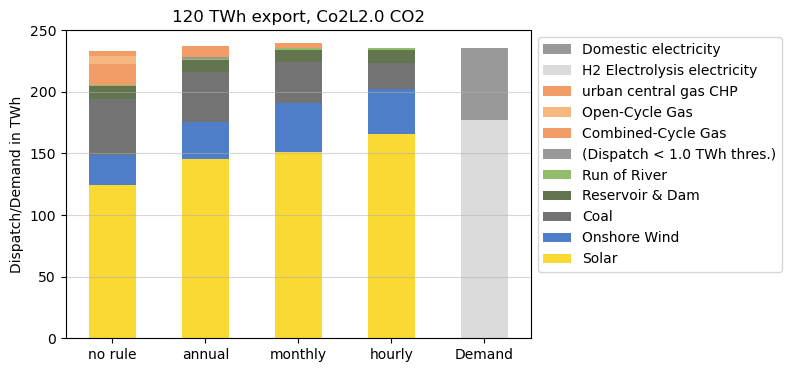

In [149]:
df = prepare_data(ghrules, h2export, opts)

fig, ax = plt.subplots(figsize=(6, 4))

colors = config["plot"]["tech_colors"]
# Sort columns by highest value in first row
dispatch_sorted = dispatch[dispatch.iloc[3].sort_values(ascending=False).index]
dispatch_twh = dispatch_sorted / 1e6 # in TWh

# This line in case of electricty line not bar
# dispatch_twh = dispatch_twh.iloc[:, ~dispatch_twh.columns.isin(["H2 Electrolysis electricity", "Domestic electricity"])]
# dispatch[["H2 Electrolysis electricity", "Domestic electricity"]].div(1e6).plot.line(ax=ax, alpha=1, color=colors)

dispatch_twh.plot.bar(ax=ax, stacked=True, alpha=0.8, color=colors)

#plt.xlabel("H2 rule")
plt.ylabel("Dispatch/Demand in TWh")
plt.title(f"{h2export} TWh export, {opts} CO2")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.ylim(0, 250)

plt.grid(axis='y', alpha=0.5) 

fig.savefig(OUTPUT+f"dispatch_{h2export}_{opts}.pdf", bbox_inches="tight")

In [151]:
dispatch_twh

carrier,Solar,Onshore Wind,Coal,Reservoir & Dam,Run of River,(Dispatch < 1.0 TWh thres.),Combined-Cycle Gas,Open-Cycle Gas,urban central gas CHP,H2 Electrolysis electricity,Domestic electricity
no rule,124.154061,24.507708,45.506472,10.204216,1.253504,0.269297,16.784636,6.721901,3.968176,NaN,NaN
annual,145.425884,30.481334,40.115899,9.621615,1.254926,1.184502,9.128450,NaN,NaN,NaN,NaN
monthly,151.300951,39.564801,33.227225,9.929010,1.252163,0.012708,4.527602,NaN,NaN,NaN,NaN
hourly,165.703522,36.400695,21.698959,10.191259,1.251055,0.046391,NaN,NaN,NaN,NaN,NaN
Demand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.161885,58.129997


### n.statistics() tests

CAPEX and OPEX: works

In [96]:
n.objective / 1e9 - (n.statistics.capex().sum() + n.statistics.opex().sum() - n.statistics.installed_capex().sum() )/ 1e9

-1.1543288991333611e-08

In [97]:
n.objective / 1e9

25.82415228507718

In [98]:
n.statistics.capex().sum() / 1e9

30.830772089885194

In [99]:
n.statistics.opex().sum() / 1e9

0.5302521875198635

In [100]:
n.statistics.installed_capex().sum() / 1e9

5.536871980784589

In [101]:
n.statistics.opex().sort_values() / 1e9

component  carrier                                
Store      co2 stored                                -2.586592e-04
           urban central water tanks                 -5.096963e-08
           services urban decentral water tanks      -1.368219e-10
           residential rural water tanks             -1.321028e-10
           residential urban decentral water tanks   -1.292152e-10
                                                          ...     
Generator  Solar                                      7.413129e-03
Store      Oil                                        2.375936e-02
Link       solid biomass transport                    9.104645e-02
Store      solid biomass                              1.633375e-01
Generator  Oil                                        2.345235e-01
Length: 80, dtype: float64

Revenue

In [102]:
# Expenses
n.statistics.revenue()[n.statistics.revenue() <0].sum() / 1e9

-39.19866687427237

In [103]:
# Incomes
n.statistics.revenue()[n.statistics.revenue() >0].sum() / 1e9

39.198666770826875

In [104]:
n.statistics.revenue()[n.statistics.revenue() >0].sort_values() / 1e9

component    carrier                                        
Store        gas                                                3.417177e-11
Link         residential urban decentral water tanks charger    5.083015e-08
             residential rural water tanks charger              5.186485e-08
             services rural water tanks charger                 5.263007e-08
Generator    Coal                                               1.432103e-07
             Offshore Wind (AC)                                 1.458250e-07
             residential rural solar thermal                    2.794136e-07
             services rural solar thermal                       2.794150e-07
             residential urban decentral solar thermal          3.098409e-07
Store        services urban decentral water tanks               4.699444e-07
Link         helmeth                                            7.978252e-07
             urban central gas CHP                              1.641258e-06
Generator    se

In [105]:
# n.statistics.revenue(comps=["Load"]).droplevel(0).div(1e9).plot.bar(
#     title="Revenue from load",
# )

In [106]:
n.statistics.revenue(comps=["Load"]).sort_values() / 1e9

component  carrier                     
Load       H2                             -10.327243
           process emissions               -5.557982
           oil emissions                   -4.241547
           services biomass                -3.353027
           industry coal emissions         -2.515394
           residential biomass             -2.439122
           industry oil emissions          -1.781508
           AC                              -1.339681
           industry electricity            -0.893363
           land transport EV               -0.846159
           land transport oil emissions    -0.816287
           naphtha for industry            -0.774702
           residential oil                 -0.767766
           kerosene for aviation           -0.629733
           urban central heat              -0.509933
           services electricity            -0.446561
           solid biomass for industry      -0.440897
           agriculture oil                 -0.426162
      

In [107]:
n.statistics.revenue(comps=["Load"])[n.statistics.revenue(comps=["Load"]).droplevel(0).index.str.contains("oil")].sort_values().sum() / 1e9

-8.73704905677513

In [108]:
n.statistics.revenue(comps=["Store"]).sort_values()  / 1e9

component  carrier                                
Store      co2                                       -1.077540e-02
           services rural water tanks                -4.586352e-08
           residential rural water tanks             -4.586115e-08
           residential urban decentral water tanks   -2.395405e-08
           gas                                        3.417177e-11
           services urban decentral water tanks       4.699444e-07
           battery                                    3.964612e-06
           urban central water tanks                  1.108676e-02
           Oil                                        2.375968e-02
           H2                                         5.126945e-01
           Li ion                                     5.411272e-01
           co2 stored                                 5.678019e+00
           solid biomass                              6.191556e+00
Name: stores, dtype: float64

In [109]:
n.statistics.revenue(comps=["Store"])[n.statistics.revenue(comps=["Store"]) <0].sum() / 1e9

-0.01077551874858924

In [110]:
n.statistics.revenue(comps=["Store"])[n.statistics.revenue(comps=["Store"]) >0].sum() / 1e9

12.958248529772236

Misc

In [111]:
EXPORT = 200
CO2L = 2.0
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.13

RUN = "decr_13_3h_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_Co2L{CO2L}_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"

In [112]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L2.0_3H_2030_0.13_DF_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [113]:
n.objective / 1e9

24.79284313792944

In [114]:
# Who pays?
expenses = n.statistics.revenue()[n.statistics.revenue() < 0]
expenses = expenses.droplevel(0)

In [115]:
# Filter out "emissions" from expenses
expenses_wo_em = expenses[~expenses.index.str.contains("emission")]

In [116]:
expenses[expenses.index.str.contains("emission")] / 1e9

Series([], dtype: float64)

In [117]:
expenses.sum() / 1e9

-25.77212321776441

In [118]:
expenses_wo_em.sum() / 1e9

-25.77212321776441

In [119]:
expenses_wo_em.sum() / 1e9 + n.objective / 1e9

-0.9792800798349681

In [120]:
# Who earns?
expenses = n.statistics.revenue()[n.statistics.revenue() > 0]
expenses = expenses.droplevel(0)
(expenses / 1e9).sort_values(ascending=False)

carrier
H2 Electrolysis                                    1.362336e+01
Oil                                                5.921239e+00
Solar                                              3.039392e+00
H2                                                 8.352234e-01
solid biomass                                      6.013319e-01
Coal                                               5.871391e-01
Onshore Wind                                       4.383822e-01
AC                                                 2.052817e-01
Reservoir & Dam                                    1.881784e-01
gas                                                1.472893e-01
solid biomass transport                            8.762810e-02
H2 pipeline                                        2.595912e-02
Run of River                                       2.195071e-02
urban central gas boiler                           2.087223e-02
urban central resistive heater                     1.763825e-02
urban central water tanks       